In [1]:
import numpy as np
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable
import torch.nn.functional as F

## Creating Dataset 

In [2]:
class BaseDataProvider:
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    
    
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

In [3]:
nx = 572
ny = 572

In [4]:
generator = GrayScaleDataProvider(nx, ny, cnt=20)

In [5]:
x_test, y_test = generator(1)

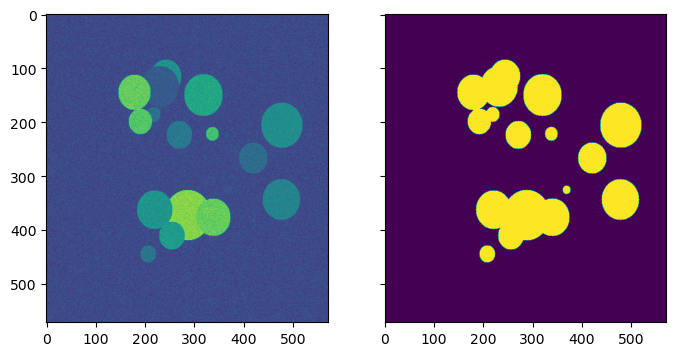

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [7]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
X_train, y_train = generator(64)
X_test, y_test = generator(16)

In [9]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(64, 572, 572, 1)

(16, 572, 572, 1)

(64, 572, 572, 2)

(16, 572, 572, 2)

In [10]:
X_train = X_train.transpose((0, 3, 1, 2))
y_train = y_train.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))
y_test = y_test.transpose((0, 3, 1, 2))

In [11]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(64, 1, 572, 572)

(16, 1, 572, 572)

(64, 2, 572, 572)

(16, 2, 572, 572)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        
        # numpy по умолчанию float64 (DoubleTensor)
        # переводим в стандартный торчевский float32 (FloatTensor)
        return torch.from_numpy(x).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

In [13]:
train_ds = CustomDataset(X_train, y_train)
test_ds = CustomDataset(X_test, y_test)

In [14]:
train_ds[0][0].device, test_ds[0][0].device

(device(type='cpu'), device(type='cpu'))

In [15]:
train_loader = DataLoader(train_ds, batch_size=1)
test_loader = DataLoader(test_ds, batch_size=1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### < check dimensions >

In [17]:
for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    print(x.shape)
    
    conv1 = nn.Conv2d(1,64, kernel_size=3, padding=0)
    conv2 = nn.Conv2d(64,64, kernel_size=3, padding=0)    
    mpool = nn.MaxPool2d(kernel_size=2, stride=2)    
    
    s = nn.Sequential(conv1, conv2, mpool)
    s.to(device)
    out = s(x)
    print(out.shape)
    
    break

torch.Size([1, 1, 572, 572])
torch.Size([1, 64, 284, 284])


### < check dimensions >

## Creating model 

In [18]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [19]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

## Train

In [20]:
model = UNet(n_channels=1, n_classes=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.to(device)
display()

In [21]:
def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).cuda(), Variable(y).cuda()
        output = model(X)
        loss += F.cross_entropy(output, y).item()
    loss = loss / len(dl)
    return loss

In [22]:
class param:
    img_size = (572, 572)
    bs = 4
    num_workers = 4
    lr = 0.001
    epochs = 5
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 1 # less then len(train_dl)

In [23]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_loader):
        X = Variable(X).cuda()  # [N, 1, H, W]
        y = Variable(y).cuda()  # [N, H, W] with class indices (0, 1)

        output = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            train_losses.append(loss.item())

            model.eval()
            val_loss = get_loss(test_loader, model)
            model.train()
            val_losses.append(val_loss)
            
    print(f"EPOCH - {epoch+1}, VAL LOSS - {val_loss:.3f}")


model.eval()
val_loss = get_loss(test_loader, model)

EPOCH - 1, VAL LOSS - 0.427
EPOCH - 2, VAL LOSS - 0.296
EPOCH - 3, VAL LOSS - 0.248
EPOCH - 4, VAL LOSS - 0.218
EPOCH - 5, VAL LOSS - 0.196


## Validation

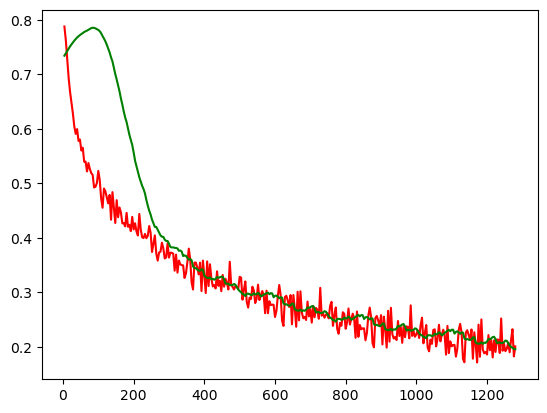

In [24]:
plt.plot(iters, train_losses, c='r')
plt.plot(iters, val_losses, c='g')
plt.show()

In [25]:
model.eval()
for X, masks in test_loader:
    X = X.cuda()
    output = model(X)
    break

In [26]:
X[0].shape, masks[0].shape, output[0].shape

(torch.Size([1, 572, 572]),
 torch.Size([2, 572, 572]),
 torch.Size([2, 572, 572]))

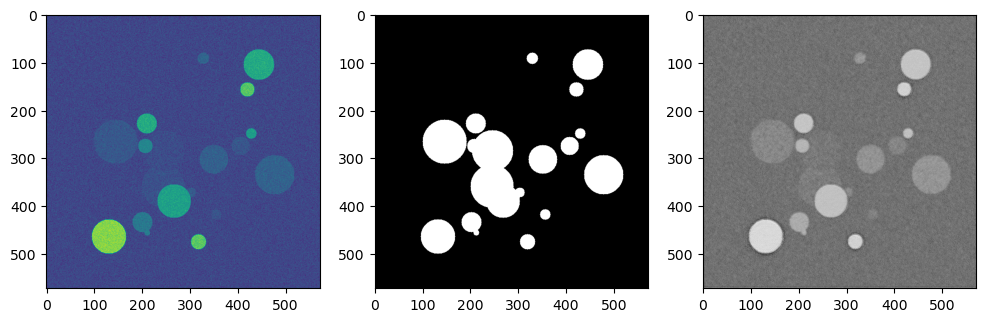

In [27]:
num_item = 0
image, mask, predicted = X[0],  masks[0][1], output[0][1]
plt.figure(figsize=(12,4))
plt.subplot(131) 
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask.cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted.detach().cpu(), cmap='gray')
plt.show()